In [62]:
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict

from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence

from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic
# from utils.regression import get_functions


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def neg_log_likelihood_loss(true_y, est_y, stddev, N, sum_batch=False, size_average=False):
    """
    Negative log-likelihood calculation
    if sum_batch=False the function returns a tensor [batch_size, 1]
    otherwise a tensor of [1]

    :param true_y: true target values
    :param est_y:  estimated target values
    :param stddev: standard deviation of normal distribution
    :param N: number of samples
    :return: negative log-likelihood: ln p(y_true | x, weights, sigma^2)
    """
    if size_average:
        avg = 1/float(N)
    else:
        avg = 1.
    ll = avg * 0.5 * 1 / stddev**2 * \
         torch.sum((true_y - est_y) ** 2, 1) + \
           N / 2 * (np.log(stddev**2) + np.log(2 * np.pi))
    if sum_batch:
        # we also sum over the mini-batch, dimension 0
        ll = torch.sum(ll)

    return ll

In [22]:
# print(torch.cuda.is_available())

# r_funcs = L2LQuadratic(batch_size=128, num_dims=10, stddev=0.01, use_cuda=False)
r_funcs = RegressionFunction(n_funcs=128, n_samples=10, x_dim=10, stddev=0.01, use_cuda=False)
loss = r_funcs.compute_loss(average=False)
neg_ll = r_funcs.compute_neg_ll(average_over_funcs=True)
print(loss.size())
print("Loss {:.4f}".format(loss.data.cpu().squeeze().numpy()[0]))
print("NLL  {:.4f}".format(neg_ll.data.cpu().squeeze().numpy()[0]))
# print(r_funcs.true_params)


torch.Size([128, 1])
Loss 61.9228
NLL  319541.3750


In [20]:
batch_size = 20
use_cuda = False
# r_funcs = L2LQuadratic(batch_size=batch_size, num_dims=10, stddev=0.01, use_cuda=use_cuda)
r_funcs = RegressionFunction(n_funcs=batch_size, n_samples=10, x_dim=10, stddev=0.01, use_cuda=use_cuda)
lr = 1e-2

print("Initial: " , r_funcs.params.data.cpu().numpy()[0, :])
print("True: " , r_funcs.true_params.data.cpu().numpy()[0, :])
losses = []
for i in range(10000):
    loss = r_funcs.compute_loss(average=False)
    losses.append(loss)
    if use_cuda:
        loss.backward(torch.ones(batch_size).cuda(), retain_variables=True)
    else:
        loss.backward(torch.ones(batch_size), retain_variables=True)
        
    # print("Sum gradients ", torch.sum(r_funcs.params.grad.data))
    new_params = r_funcs.params - lr * r_funcs.params.grad
    r_funcs.set_parameters(new_params)
    neg_ll = r_funcs.compute_neg_ll(average_over_funcs=True)
    # print("Loss {:.4f}".format(torch.mean(neg_ll).data.cpu().numpy()[0]))
    post_loss = r_funcs.compute_loss(average=True, params=None)
    # print("Loss {:.4f}".format(post_loss.data.cpu().numpy()[0]))
    r_funcs.params.grad.data.zero_()
    if post_loss.data.cpu().squeeze().numpy()[0] < 0.1:
        print("Final loss {:.5f}".format(post_loss.data.cpu().numpy()[0]))
        break
# print("Function {}".format(r_funcs.poly_desc(idx=0)))
print("Iters: {}, loss {:.5f}".format(i+1, torch.mean(loss).data.cpu().squeeze().numpy()[0]))
print(" Final params ", r_funcs.params.data.cpu().numpy()[0, :])
losses = torch.squeeze(torch.sum(torch.cat(losses, 1), 1))
print(losses.size())
losses.backward(torch.ones(batch_size))
new_params = r_funcs.params - 1e-5 * r_funcs.params.grad
r_funcs.set_parameters(new_params)
post_loss = r_funcs.compute_loss(average=True, params=None)
print("Loss: {:.5f}".format(post_loss.data.cpu().squeeze().numpy()[0]))
print(" Final params ", r_funcs.params.data.cpu().numpy()[0, :])
# print("Loss with true parameters {:.14f}".format(r_funcs.min_loss.data.cpu().numpy()[0]))

('Initial: ', array([ -6.65079715e-05,   9.03665274e-03,  -1.06075993e-02,
        -1.36997760e-03,   3.78459692e-03,   1.69263817e-02,
        -5.86713525e-03,   7.95797259e-03,  -1.45060448e-02,
        -8.19932669e-03], dtype=float32))
('True: ', array([ 0.04636235,  0.59541875,  0.73402822,  0.19001186,  0.49717197,
        0.29432291,  0.71542352,  0.66822666,  0.4238359 ,  0.34434074], dtype=float32))
Final loss 0.09945
Iters: 39, loss 0.10309
(' Final params ', array([ 0.16974671,  0.52097386,  0.58591771,  0.4453882 ,  0.36255515,
        0.32683119,  0.51719278,  0.46478206,  0.60828674,  0.31240356], dtype=float32))
torch.Size([20])
Loss: 0.09925
(' Final params ', array([ 0.16991653,  0.52148581,  0.58651423,  0.44583496,  0.36291391,
        0.32714111,  0.51771581,  0.46523887,  0.60890955,  0.31272417], dtype=float32))


In [9]:
r_funcs = RegressionFunction(n_funcs=100, n_samples=100, noise_sigma=1., poly_degree=2, non_linear=False)

E[T] 42.0
Sample mean 42.45
Sum of probs 1.00


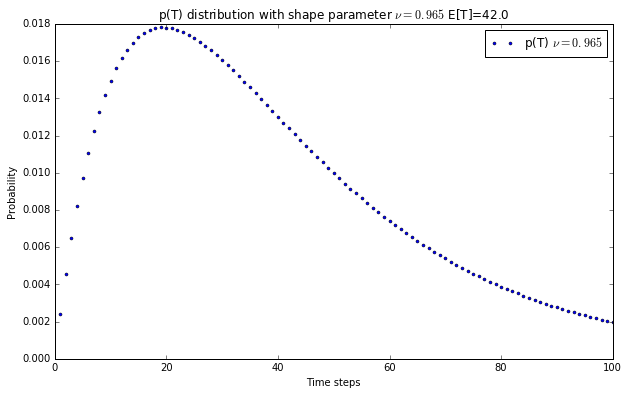

Median 34.0


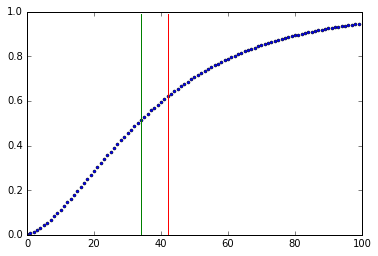

In [80]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

T = 100
q = 0.965
pmfT = TimeStepsDist(q_prob=q, T=1000) # 14/0.8

print("E[T] {}".format(pmfT.mean))
ts = pmfT.rvs(n=1500)
# print(ts)
print("Sample mean {:.2f}".format(np.mean(ts)))
# print("Get prob ", pmfT.pmfunc(np.array([3, 4, 5, 6])))
pmf = pmfT.pmfunc(normalize=True, T=T)
cdf = np.cumsum(pmf)

# choice = np.random.uniform(size=10)
# print(choice)
# index = np.zeros(len(choice)).astype(int)
# for i in range(len(choice)):
#    index[i], _ = find_nearest(cdf, choice[i])

# print("Mean ", np.mean(index))
# choice = [0.6]
print("Sum of probs {:.2f}".format(np.sum(pmfT.pdf)))

pmfT.plot_pmf(T, do_save=False, do_show=True)

_ = plt.plot(pmfT.cdf[0:T], 'bo', markersize=3)
y = np.arange(0, 1, 0.01)
mean = np.empty(100)
mean.fill(pmfT.mean)
median = np.empty(100)
median.fill(pmfT.median)
print("Median {}".format(pmfT.median))
plt.plot(mean, y, 'r')
plt.plot(median, y, 'g')
plt.show()

In [61]:
new_p = np.zeros(pmfT.H)
for i in np.arange(pmfT.H):
    new_p[i] = pmfT.pdf[i] + np.sum(pmfT.cdf[i+1:])

0.0255020772368
0.48369417452
0.0123352061976
Variable containing:
 9.8825e-08
 2.6864e-07
 8.0079e-04
 2.1768e-03
 1.1885e-01
 8.7817e-01
[torch.FloatTensor of size 6]



E[t|50] 13.0


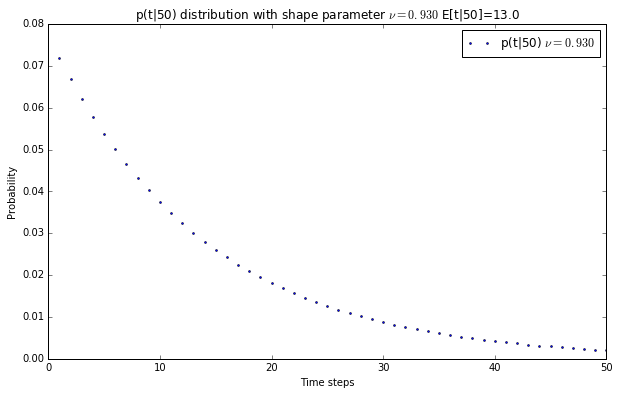

In [27]:
q = 0.93
T=50
pmf_t_T = ConditionalTimeStepDist(T, q)
print("E[t|{}] {}".format(T, pmf_t_T.mean))
priors = Variable(torch.from_numpy(pmf_t_T.pmfunc(T=T, normalize=True)).float())

samples = pmf_t_T.rvs(n=1000000)
# plt.hist(samples, bins=T, normed=True)
pmf_t_T.plot_pmf(do_save=False, do_show=True)
# print("{}".format(np.array_str(priors.data.numpy())))

In [13]:
np.sum(priors.data.numpy())

0.99999988

In [33]:
qt = np.array([  3.5374e-57,   1.0894e-56,   2.9237e-56,   8.1168e-56,   2.4303e-55,
   7.8928e-55,   2.7671e-54,   1.0375e-53,   4.1141e-53,   1.7077e-52,
   7.3567e-52,   3.2699e-51,   1.4881e-50,   6.8986e-50,   3.2434e-49,
   1.5402e-48,   7.3734e-48,   3.5472e-47,   1.7114e-46,   8.2555e-46,
   1.8072e-45,   3.5995e-45,   7.6743e-45,   1.8595e-44,   5.2279e-44,
   1.6857e-43,   6.0178e-43,   2.3144e-42,   9.3980e-42,   3.9703e-41,
   1.7292e-40,   7.7205e-40,   3.5106e-39,   1.6162e-38,   7.4983e-38,
   3.4950e-37,   1.6351e-36,   7.6630e-36,   3.5991e-35,   1.6895e-34,
   3.6486e-34,   7.1267e-34,   1.4746e-33,   3.4694e-33,   9.5001e-33,
   2.9994e-32,   1.0618e-31,   4.0581e-31,   1.6410e-30,   6.9501e-30,
   3.0378e-29,   1.3630e-28,   6.2531e-28,   2.9126e-27,   1.3689e-26,
   6.4614e-26,   3.0598e-25,   1.4492e-24,   6.8716e-24,   3.2535e-23,
   7.0361e-23,   1.3707e-22,   2.8222e-22,   6.6022e-22,   1.8029e-21,
   5.6797e-21,   2.0004e-20,   7.6115e-20,   3.0600e-19,   1.2873e-18,
   5.5859e-18,   2.4871e-17,   1.1317e-16,   5.2226e-16,   2.4347e-15,
   1.1413e-14,   5.3754e-14,   2.5340e-13,   1.1977e-12,   5.6558e-12,
   1.2228e-11,   2.3864e-11,   4.9239e-11,   1.1532e-10,   3.1436e-10,
   9.8838e-10,   3.4828e-09,   1.3241e-08,   5.3262e-08,   2.2427e-07,
   9.7413e-07,   4.3450e-06,   1.9813e-05,   9.1626e-05,   4.2797e-04,
   2.0097e-03,   9.4783e-03,   4.4737e-02,   2.1160e-01,   1.0000e+00])

In [34]:
steps = 10
pmf_pt_T = ConditionalTimeStepDist(steps, 0.82)
print("Mean ", pmf_pt_T.mean)
priors = Variable(torch.from_numpy(pmf_pt_T.pmfunc(np.arange(0, steps), normalize=True)).float())
print("Sum priors {:.3}".format(torch.sum(priors).data.squeeze().numpy()[0]))
print("Length prior {}".format(priors.size(0)))
print("Priors {}".format(np.array_str(priors.data.squeeze().numpy(), precision=4)))
print("Samples {}".format(pmf_pt_T.rvs(n=10)))

('Mean ', 4.0)
Sum priors 1.22
Length prior 10
Priors [ 0.2545  0.2087  0.1711  0.1403  0.1151  0.0944  0.0774  0.0634  0.052
  0.0427]
Samples [ 4  5  3  3  6  6 10  3  2  3]


T = 15
('Cumsum ', 1.0)
Mean 4.00
CDF prior probs [ 0.25911686  0.46641034  0.63224512  0.76491296  0.87104726  0.95595467
  1.0238806   1.07822132  1.12169397  1.15647209  1.18429458  1.20655251
  1.22435892  1.23860407  1.25000012]
Sum prior_dist 1.25


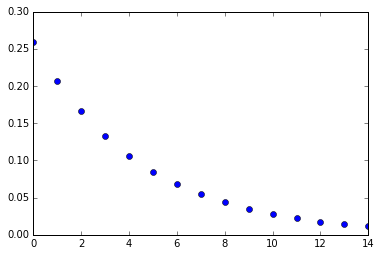

In [81]:
continue_prob = 0.8
pt_dist = TimeStepsDist(config.T, continue_prob)
# optimizer_steps = pt_dist.rvs(n=1)
optimizer_steps = 15
print("T = {}".format(optimizer_steps))

prior_dist = ConditionalTimeStepDist(optimizer_steps, q_prob=continue_prob)
print("Cumsum ", prior_dist.cdf[-1])
print("Mean {:.2f}".format(prior_dist.mean))
prior_probs = Variable(torch.from_numpy(prior_dist.pmfunc(np.arange(0, optimizer_steps), normalize=True)).float())
print("CDF prior probs {}".format(np.cumsum(prior_probs.data.squeeze().numpy())))
# t = np.arange(optimizer_steps)
# prior_probs = pmf_ptT(t, optimizer_steps, config.continue_prob)
# print(torch.sum(prior_probs.data.squeeze()))
print("Sum prior_dist {:.2f}".format(torch.sum(prior_probs.data.squeeze())))
# print("Sum prior_dist {:.8f}".format(np.sum(prior_probs)))
plt.plot(prior_probs.data.squeeze().numpy(), 'bo')

In [33]:
def pmf_pt(T_horizon, q_prob):
    
    PT_dists = {}
    pt_T_dists = {}
    for T in range(1, T_horizon+1):
        dist = TimeStepsDist(T, q_prob)
        PT_dists[T] = dist.pmfunc(np.arange(1, T+1), normalize=True)
    for t in range(1, T_horizon+1):
        dist = ConditionalTimeStepDist(t, q_prob)
        pt_T_dists[t] = dist.pmfunc(np.arange(1, t+1), normalize=True)
        
    probs = []
    t_values = range(1, T_horizon+1)
    
    for t in t_values:
        T_range = range(t, T_horizon+1)
        T_sum = 0.
        for T in T_range:
            
            prob = pt_T_dists[T][t-1] * PT_dists[T][t-1]
            print("p(t) {:.3f} += {:.3f} p({}|{}) * p({})".format(T_sum, prob, t, T, T))
            T_sum += prob
        probs.append(T_sum)
        
    return np.array(probs)

pt = pmf_pt(3, 0.8)    
print("Ready len(pt)={}".format(len(pt)))
print(pt)

p(t) 0.000 += 1.000 p(1|1) * p(1)
p(t) 1.000 += 0.267 p(1|2) * p(2)
p(t) 1.267 += 0.131 p(1|3) * p(3)
p(t) 0.000 += 0.231 p(2|2) * p(2)
p(t) 0.231 += 0.113 p(2|3) * p(3)
p(t) 0.000 += 0.088 p(3|3) * p(3)
Ready len(pt)=3
[ 1.39729359  0.34467426  0.08784334]


In [38]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [58]:
import models.rnn_optimizer
myclass = getattr(models.rnn_optimizer, "AdaptiveMetaLearner"+"V2")

In [179]:
def pmf_ptT(t, T, q_prob):
    p = 1 - q_prob
    return (p * q_prob**t) / (1 - q_prob**(T+1))

In [46]:
def bh(m,go,gi):
    print("Grad Input")
    print(go)
    print("Grad Output")
    print(gi)
    

class M(nn.Module):
    def __init__(self, dim_out):
        super(M,self).__init__()
        self.ln1 = nn.Linear(1, dim_out)
        self.ln2 = nn.Linear(dim_out, 1)
        # self.register_backward_hook(bh)


    def forward(self,x1):
        # x2 = x1.clone()
        # out1 = self.ln1(x1)
        # out2 = torch.sum(self.ln1(x2))   
        w = torch.sum(x1).unsqueeze(1)
        x1 = torch.cat((x1, x1), 0)
        print("x1.size( )", x1.size())
        x_out = []
        q_out = []
        parms = x1.size(1)
        print("num parms {}".format(parms))
        
        for i, p in enumerate(x1.t()):
            print()
            h1 = self.ln1(p.unsqueeze(1))
            h2 = self.ln2(h1)
            x = h2[0].unsqueeze(1)
            q = h2[1].unsqueeze(1)
            
            x_out.append(x)
            q_out.append(q)
        x_out = torch.cat(x_out)
        q_out = torch.sum(torch.cat(q_out), 0)
                             
        return x_out, q_out
    
    def print_grads(self):
        sum_grads = 0.
        for p in self.parameters():
            sum_grads += torch.sum(p.grad.data)
        print("sum_grads {:.4f}".format(sum_grads))

dim1 = 3
dim_out = 4

x=Variable(torch.randn(1,dim1),requires_grad=False)
y=Variable(torch.randn(1,dim1),requires_grad=False)
# z=Variable(torch.randn(1,dim1),requires_grad=True)
true_val = Variable(torch.randn(dim1))

criterion=nn.MSELoss()
mod=M( dim_out)
optimizer = optim.Adam(mod.parameters(), lr=0.4)
coeff = []
losses = []

print("x ", np.array_str(x.data.numpy()))

for i in range(3):
    out1, out2 = mod(x)
    coeff.append(out2)
    print("qi {:.3f}".format(out2.data.squeeze().numpy()[0]))
    loss1 = criterion(out1,true_val)
    losses.append(Variable(loss1.data * 1000))
    print("loss1 {:.3f}".format(loss1.data.numpy()[0]))
    loss1.backward()
    # print("grads {}".format(torch.sum(x.grad.data)))
    optimizer.step()
    print("x ", np.array_str(x.data.numpy()))
    mod.print_grads()
    mod.zero_grad()
        
coeff = torch.cat(coeff, 0)
comps = torch.cat(losses, 0)
print(coeff.size(), comps.size())
probs = F.softmax(coeff.squeeze())
print("probs {}".format(np.array_str(probs.data.numpy())))
loss2 = torch.sum(comps * probs)
loss2.backward()
mod.zero_grad()
# print("grads {}".format(torch.sum(x.grad.data)))
optimizer.step()
# print("x ", np.array_str(x.data.numpy()))

('x ', '[[ 0.92310804  1.11475897 -0.1499422 ]]')
('x1.size( )', torch.Size([2, 3]))
num parms 3
qi 0.505
loss1 0.891
('x ', '[[ 0.92310804  1.11475897 -0.1499422 ]]')
sum_grads -1.5329
('x1.size( )', torch.Size([2, 3]))
num parms 3
qi 4.461
loss1 0.413
('x ', '[[ 0.92310804  1.11475897 -0.1499422 ]]')
sum_grads 0.4270
('x1.size( )', torch.Size([2, 3]))
num parms 3
qi -0.028
loss1 1.456
('x ', '[[ 0.92310804  1.11475897 -0.1499422 ]]')
sum_grads -1.4040
(torch.Size([3, 1]), torch.Size([3]))
probs [ 0.01857823  0.97051847  0.01090329]


RuntimeError: Trying to backward through the graph second time, but the buffers have already been freed. Please specify retain_variables=True when calling backward for the first time.

In [37]:
input_num = 10
hidden_num = 20

lstms = nn.ModuleList()
for i in range(num_layers):
    self.lstms.append(LayerNormLSTMCell(num_hidden, num_hidden))

input = Variable(torch.randn(6, 3, 10))
hx = Variable(torch.randn(3, 20))
output = []
for i in range(6):
    hx = rnn(input[i], hx)
    output.append(hx)

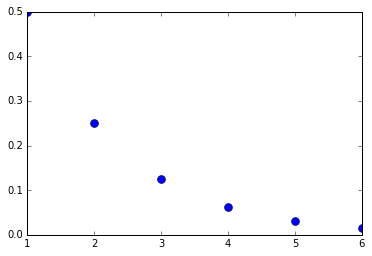

In [12]:
plt.plot(x, stats.geom.pmf(x, p), 'bo', ms=8, label='geom pmf')

In [28]:
x = np.linspace(-2, 2, 1000)
y = np.linspace(-2, 2, 1000)

X, Y = np.meshgrid(x,y)
Z = np.exp(-0.5 * (X**2 + Y**2))

In [29]:
np.array(Z).shape

(1000, 1000)

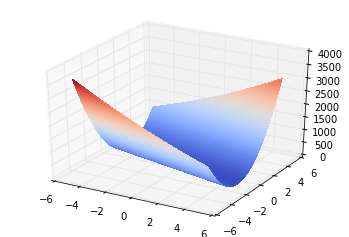

In [61]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

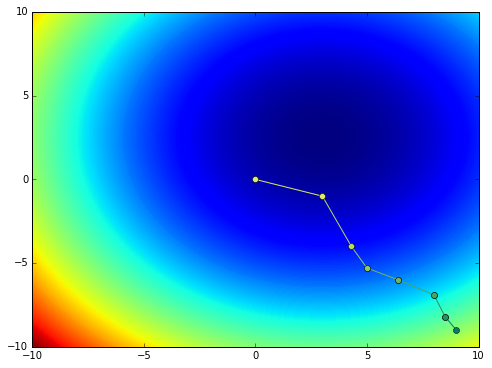

In [23]:
from cycler import cycler
MAP = 'summer'
cm = plt.get_cmap(MAP)

plt.figure(figsize=(8,6))
ax = plt.gca()
plt.contourf(X, Y, Z, 300)
x_point = [9, 8.5, 8, 6.4, 5, 4.3, 3, 0]
y_point = [-9, -8.2, -6.9, -6, -5.3, -4, -1, 0]
NPOINTS = len(x_point)
# ax.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
ax.set_prop_cycle(cycler('color', plt.cm.Accent(np.linspace(0, 1, NPOINTS))))
ax.set_prop_cycle(cycler('color', [cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)]))

for i in range(NPOINTS-1):
    ax.plot(x_point[i:i+2],y_point[i:i+2], 'o-')
# plt.axis('off')
plt.show()

In [127]:

print("minimum at (%.3f/%.3f) with value %.4f" % (X.ravel()[np.argmin(Z)], Y.ravel()[np.argmin(Z)], np.min(Z)))

minimum at (4.334/7.437) with value 123.9278


In [128]:
from scipy.optimize import minimize
minimize(quad_2D, [2,4], args=(W), method='BFGS')

      fun: 123.92781597315845
 hess_inv: array([[ 3.84370028,  4.17917771],
       [ 4.17917771,  7.14183093]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([ 4.33719279,  7.43479978])

In [130]:
Z.shape

(1000, 1000)

In [13]:
myfunc = lambda x: torch.sum((x+2.45)**2 * 2.34)
x = Variable(torch.FloatTensor([6]), requires_grad=True)
meta_x = Variable(torch.FloatTensor([6]), requires_grad=True)
loss = myfunc(x)
meta_loss = myfunc(meta_x)
loss_sum = 0
for i in np.arange(200):
    loss_sum = loss_sum + meta_loss
    loss = myfunc(x)
    loss.backward()
    # print("grads {:.3f}".format(torch.mean(x.grad).data.numpy()[0]))
    x_new = x - 0.01 * x.grad
    x.grad.data.zero_()
    x.data.copy_(x_new.data)
    if i == 1:
        meta_x.data.copy_(x_new.data)
    else:
        meta_x = Variable(x_new.data, requires_grad=True)
    # print("new x ", x.data.numpy())
    loss = myfunc(x)
    meta_loss = myfunc(meta_x)

loss_sum.backward()
print("grads {:.3f}".format(torch.mean(meta_x.grad).data.numpy()[0]))
print("new x ", x.data.numpy())
print("meta_x ", meta_x.data.numpy())

TypeError: torch.mean received an invalid combination of arguments - got (NoneType), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, int dim)


In [20]:
class MyFunc(object):
    def __init__(self):
        self.f = lambda x: torch.sum((x+2.45)**2 * 2.34)
        self.x = Variable(torch.FloatTensor([6]), requires_grad=True)

func = MyFunc()
optimizer = optim.Adam([func.x], lr=1e-3)
for i in np.arange(10):
    loss = func.f(func.x)
    loss.backward()
    optimizer.step()
    x.grad.data.zero_()
    print("Current x-value {:.3f}".format(func.x.data.numpy()[0]))

Current x-value 5.999
Current x-value 5.998
Current x-value 5.997
Current x-value 5.996
Current x-value 5.995
Current x-value 5.994
Current x-value 5.993
Current x-value 5.992
Current x-value 5.991
Current x-value 5.990


In [173]:
rnn = nn.LSTM(1, 20, 2)
input = Variable(torch.randn(5, 3, 1))
h0 = Variable(torch.randn(2, 3, 20))
c0 = Variable(torch.randn(2, 3, 20))
output, hn = rnn(input, (h0, c0))

In [174]:
for param_name, params in rnn._parameters.iteritems():
    print(params.size())

torch.Size([80, 1])
torch.Size([80, 20])
torch.Size([80])
torch.Size([80])
torch.Size([80, 20])
torch.Size([80, 20])
torch.Size([80])
torch.Size([80])


In [2]:
q2_func = Quadratic2D(False)

meta_optimizer = MetaLearner(HelperQuadratic(q2_func), num_layers=2, num_hidden=20, use_cuda=False)
print(meta_optimizer.state_dict().keys())
for child in meta_optimizer.children():
    print(child.state_dict().keys())

meta_optimizer.load_state_dict(torch.load('meta_learner_v1.pkl'))

['linear1.weight', 'linear1.bias', 'ln1.weight', 'ln1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.0.ln_i2h.weight', 'lstms.0.ln_i2h.bias', 'lstms.0.ln_h2h.weight', 'lstms.0.ln_h2h.bias', 'lstms.0.ln_h2o.weight', 'lstms.0.ln_h2o.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'lstms.1.ln_i2h.weight', 'lstms.1.ln_i2h.bias', 'lstms.1.ln_h2h.weight', 'lstms.1.ln_h2h.bias', 'lstms.1.ln_h2o.weight', 'lstms.1.ln_h2o.bias', 'linear_out.weight', 'linear_out.bias']
['weight', 'bias']
['weight', 'bias']
['0.fc_i2h.weight', '0.fc_i2h.bias', '0.fc_h2h.weight', '0.fc_h2h.bias', '0.ln_i2h.weight', '0.ln_i2h.bias', '0.ln_h2h.weight', '0.ln_h2h.bias', '0.ln_h2o.weight', '0.ln_h2o.bias', '1.fc_i2h.weight', '1.fc_i2h.bias', '1.fc_h2h.weight', '1.fc_h2h.bias', '1.ln_i2h.weight', '1.ln_i2h.bias', '1.ln_h2h.weight', '1.ln_h2h.bias', '1.ln_h2o.weight', '1.ln_h2o.bias']
['weight', 'bias']


In [7]:
myfunc_list = []
for i in np.arange(20):
    f = Quadratic2D()
    myfunc_list.append(f)
    

myfunc_file = os.path.join("utils", "val_functions.pkl")
with open(myfunc_file, 'wb') as f:
    dill.dump(myfunc_list, f)



In [49]:
myfunc_file = os.path.join("logs/run_20170322_14_00_47", "diff_funcs.dll")
with open(myfunc_file, 'rb') as f:
    loaded_funcs = dill.load(f)
    
for i in np.arange(len(loaded_funcs)):
    myfunc = loaded_funcs[i]
    print("{} func: {}".format(i+1, loaded_funcs[i].poly_desc))
    print("Minimum {:.3f}, {:.3f}".format(loaded_funcs[i].true_opt[0].data.numpy()[0],
                                         loaded_funcs[i].true_opt[1].data.numpy()[0]))
    print("Final parameter values ({:.2f},{:.2f})".format(myfunc.parameter[0].data.numpy()[0],
                                                          myfunc.parameter[1].data.numpy()[0]))
    


1 func: ((x1-1.50)^2/0.03^2+(x2-1.27)^2/0.03^2)+0.44
Minimum 1.496, 1.274
Final parameter values (1.03,23.35)


In [39]:
exp_filename1 = "logs/run4/run_2017-03-22 11:22:26.844.dll"
with open(exp_filename1, 'rb') as f:
    exper1 = dill.load(f)

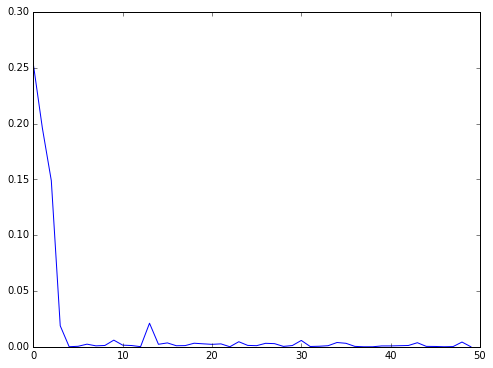

In [47]:

plt.figure(figsize=(8, 6))
plt.plot(exper1.val_stats['param_error'])

In [6]:
exper_2 = get_experiment("run_20170428_18_46_11_actV1_50ep_10ops_lr1e05_adam")
explogger2 = create_logger(exper_2, file_handler=False)
model_meta_exp2 = get_model(exper_2, retrain=True, logger=explogger2)

INFO - INFO - loaded existing model from file logs/run_20170408_19_12_16_meta_45ep_10ops_lr1e04/meta_lr1e-04_10ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170408_19_12_16_meta_45ep_10ops_lr1e04/meta_lr1e-04_10ops.pkl


In [13]:
val_funcs = [Quadratic2D() for i in range(100)]
with open("data/validation_functions.dll", 'wb') as f:
    dill.dump(val_funcs, f)
print("Success")

Success


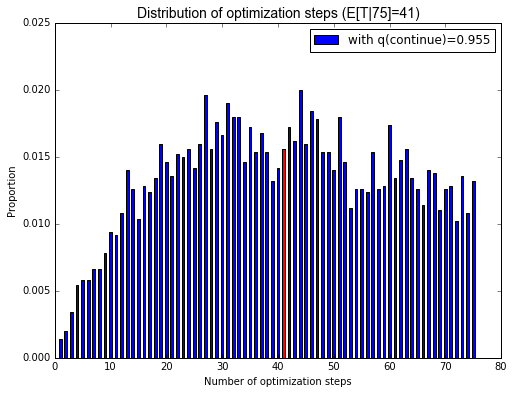

In [63]:
plot_dist_optimization_steps(exper1, data_set="train", show=True, save=False)

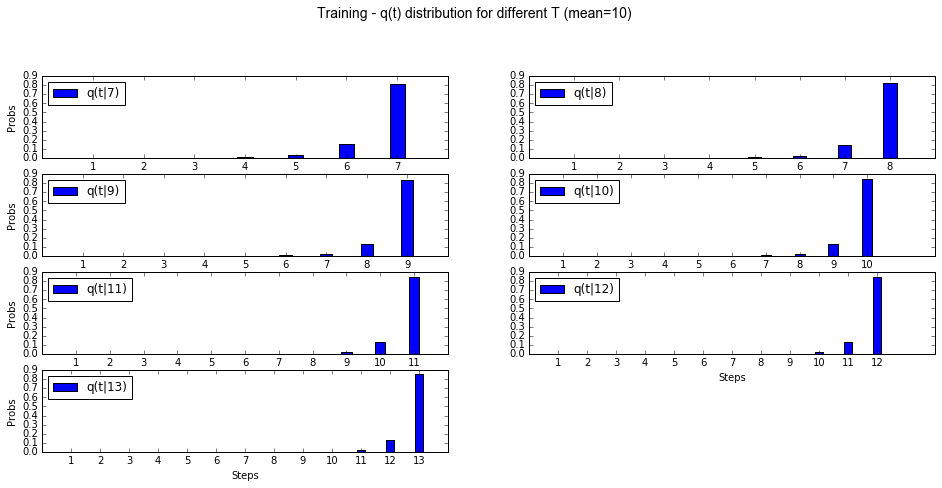

In [72]:
np.sum(exper1.val_stats["opt_step_hist"] != 0) == 1
plot_qt_probs(exper1, data_set="train", show=True, plot_prior=False)

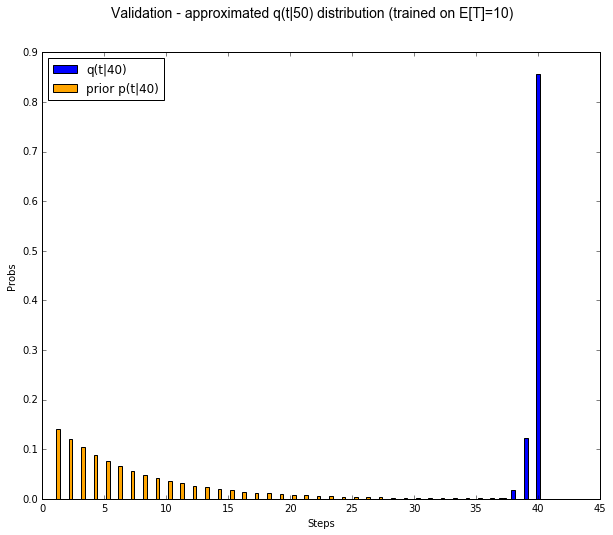

In [73]:
plot_qt_probs(exper1, data_set="val", show=True, plot_prior=True)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  10.]
Mean 20


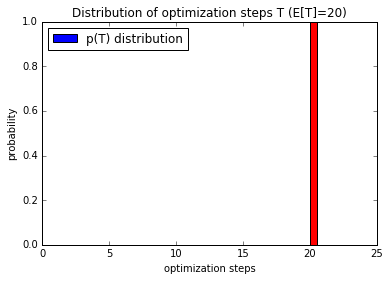

20
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [45]:
bar_width = 0.5
data_set = "val"
if data_set == "train":
    opt_step_hist = exper1.epoch_stats["opt_step_hist"]
else:
    opt_step_hist = exper1.val_stats["opt_step_hist"]
    print(opt_step_hist)
    
index = range(1, len(opt_step_hist)+1)
norms = 1./np.sum(opt_step_hist) * opt_step_hist
o_mean = int(round(np.sum(index * norms)))
print("Mean {}".format(o_mean))

plt.bar(index, norms, bar_width, color='b', label="p(T) distribution")
plt.bar([o_mean], norms[o_mean-1], bar_width, color='r')
plt.xlabel("optimization steps")
plt.ylabel("probability")
plt.title("Distribution of optimization steps T (E[T]={})".format(o_mean))
plt.legend(loc="best")
plt.show()
print(len(opt_step_hist))
print(opt_step_hist[0:10])

[ 2  3 29 28  1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27  0]
[2 3]
('plot_idx ', [3, 4])
INFO - Successfully saved fig logs/run_20170404_11_36_20_actV1_15ep_6ops_EVAL/qt_T_dist_val_actV1_15ep_6ops_EVAL.png


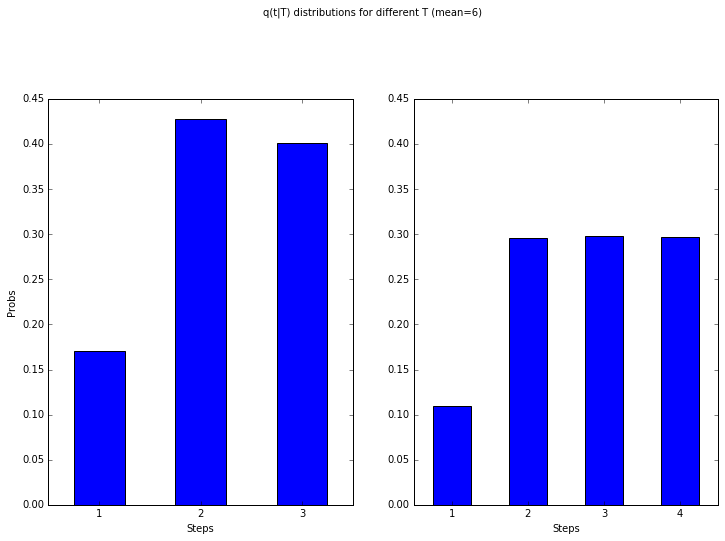

In [46]:
print(np.argsort(opt_step_hist)[::-1])
print(np.argsort(opt_step_hist)[::-1][0:2])
plot_qt_probs(exper1, data_set="val", show=True, save=True)

In [58]:
val_funcs = [Quadratic2D() for i in range(500)]